<img style="float: right;" src="imgs/unifor.jpg" width="150px">

# **Política no Twitter**

Usamos redes sociais para estabelecer contatos, exposição profissional e expressar opiniões. Redes como [Twitter](https://twitter.com](https://twitter.com/) e [Facebook](https://www.facebook.com/) recebem diariamente milhões de postagens e comentários de seus usuários. Considerando esse cenário, _seria possível observar padrões de comportamento em mensagens postadas no Twitter?_

Este Notebook analisa dados da conta de dois políticos brasileiros, [Lula](https://twitter.com/LulaOficial) e [Jair Bolsonaro](https://twitter.com/jairbolsonaro) na tentativa de identificar esses padrões. 

Trabalho como resultado de Projeto da disciplina de **Introdução a Ciência de Dados**.

## **Ambiente**
Utilizamos [Python](https://www.python.org/) no ambiente [Jupyter](https://jupyter.org/) para desenvolver os Notebooks.

Para montar o ambiente de execução você precisará de uma versão do [Conda](https://sandbox.anaconda.com/) e opcionalmente o [Git](https://git-scm.com/). Você encontrará instrução de instalação desses produtos em seus próprios sites.

```bash
git clone https://github.com/michelav/projeto-twitter.git
cd projeto-twitter
source path_to_conda/activate
conda env create -f environment.yml
conda activate ptwitter
jupyter-lab
```

## **Dados**

O _dataset_ contém todos os tweets publicados pelos dois políticos até o fim de 2019. Esses tweets estão divididos em dois (um para cada político) arquivos texto no formato ```json```. Os arquivos foram extraídos por meio da API Web da plataforma e seguem o formato definido no [_hotsite_](https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/intro-to-tweet-json) da API.

## **Análise Exploratória**

Para a análise exploratória utilizaremos a biblioteca Pandas. Ele permite que organizemos os dados em _frames_ que permitem consulta, agregação e processamento massivo de dados.

In [1]:
import pandas as pd
import numpy as np

A API de I/O do Pandas fornece um conjunto vasto de métodos para leitura (_readers_) e escrita (_writers_) de dados  (texto, binários, dados hierárquicos, etc). Há um leitor específico para o formato json acessível pela operação ```pd.read_json```. Os detalhes sobe leitura e escrita de dados em json estão disponíveis no guia de usuário do pandas, na [seção específica](https://pandas.pydata.org/docs/user_guide/io.html#json) para o formato.

<div class="alert alert-block alert-info">
    <b>Importante:</b> Fique atento ao tamanho do <em>dataset</em> e a forma de carga e processamento de dados no Pandas. Os leitores de dados do Pandas fazem inferência sobre o tipo da informação encontrada no dado e, em algumas siuações, fazer conversões inadequadas (e lentas) durante a carga desse dado.</div>

Para esse trabalho, decidimos utilizar a API do Python para fazer a leitura e conversão dos dados (por exemplo, ```str``` para ```datetime```). 
O Processo de leitura e criação do _Dataframe_ pode ser descrito nas seguintes etapas:

+ Iteração pelos arquivos existente;
+ Processamento personalisado do arquivo json (ver ```process_tweets```)
+ Criação do Dataframe para cada arquivo
+ Pequeno saneamento (remoção de colunas desnecessárias, normalização do objeto entities, etc)
+ Concatenação dos dataframes em um só

In [2]:
import os
import datetime as dt
import json
from pandas.api.types import CategoricalDtype

dfs = []
profiles = []
profile_counts = {}

# Colunas removidas e que nao serao utilizadas nesse trabalho
to_be_dropped = ['id', 'display_text_range', 'source', 
                 'in_reply_to_status_id', 'in_reply_to_status_id_str', 'entities',
                 'in_reply_to_user_id', 'in_reply_to_user_id_str', 'user',
                 'in_reply_to_screen_name', 'geo', 'coordinates', 'place',
                 'contributors', 'is_quote_status', 'lang', 'extended_entities',
                 'quoted_status_id', 'quoted_status_id_str', 'quoted_status_permalink']


# object_hook para processar as strings do json como datetime
def process_tweets(dct):
    # Chaves e sub-chaves usadas para decompor as informacoes de hashtags e mencoes 
    meta = {'hashtags': 'text', 'user_mentions': 'screen_name'}
    if 'created_at' in dct:
        try:
            dct['created_at'] = dt.datetime.strptime(dct['created_at'],'%a %b %d %H:%M:%S %z %Y').replace(hour=0, minute=0, second=0, microsecond=0)
        except ValueError:
            dct['created_at'] = np.nan
    if 'user' in dct:
        dct['user.followers_count'] = dct['user']['followers_count']
        dct['user.friends_count'] = dct['user']['friends_count']
    
    if 'entities' in dct:
        try:
            # Procura pelas chaves de Meta no dicionario que represanta o Json
            # Itera pela lista de dicionarios em cada chave encontrada(ver estrutura do json) e agrega as sub-chaves em uma lista
            for k, sk in meta.items():
                items = dct['entities'][k]
                fkey = "entities.{}".format(k)
                dct[fkey] = [ivalue for item in items for ikey, ivalue in item.items() if ikey == sk] if items else np.nan
        except KeyError:
            pass
    return dct

with os.scandir('dados') as lsit:
    fit = (f for f in lsit if f.is_file())
    for f in fit:
        with open(f.path, mode='r', encoding='utf-8') as fp:
            profile = f.name.split('.')[0]
            profiles.append(profile)
            tweets = json.load(fp, object_hook=process_tweets)
            profile_counts[profile] = len(tweets)
            df = pd.DataFrame(tweets)
            
            # TODO: A remoção das colunas durante a carga do json tornaria esse processo mais rápido?
            df.drop(columns=to_be_dropped, inplace=True)
            df['tweet_len'] = df['full_text'].str.len()
            df['word_cnt'] = df['full_text'].str.count(r'\w+')
            df['full_text'] = df['full_text'].str.lower()
            df['profile'] = profile
            dfs.append(df)

tweets_df = pd.concat(dfs)
cat_type = CategoricalDtype(categories=profiles , ordered=True)
tweets_df['profile'] = tweets_df['profile'].astype(cat_type)

O dataframe ```tweets_df``` contém os dados carregados. Para facilitar agrupamento futuro, criaremos um índice baseado no perfil do usuário, data e id do tweet.

In [3]:
indexed_df = tweets_df.set_index(['profile', 'created_at', 'id_str'])
indexed_df.sort_index(inplace=True)

### Contagem de tweets por Perfil

In [4]:
for profile, count in profile_counts.items():
    print("Perfil: {0}, {1} tweets.".format(profile, count))
print("Total de tweets: {}.".format(sum(profile_counts.values())))

Perfil: jairbolsonaro, 6794 tweets.
Perfil: LulaOficial, 14961 tweets.
Total de tweets: 21755.


**Jair Bolsonaro**

In [5]:
indexed_df.loc['jairbolsonaro']

full_text  \
created_at                id_str                                                                   
2010-04-01 00:00:00+00:00 11398556610          boa noite a todos @depchicolanecar @reportercrime   
                          11398669496          me desculpem, boa noite @depchicoalencar @repo...   
                          11399072031          os militares assumiram o governo em março de 6...   
                          11399181472          em 64, o povo ñ suportava + greves, desordem s...   
                          11399973381          #debate64 o governo se fez enérgico. os q pega...   
...                                                                                          ...   
2020-01-08 00:00:00+00:00 1214931680030580737  - a partir dessa premissa (art. 7°) nota-se qu...   
                          1214931682207371266  - não foi a lei orçamentária que criou o "fund...   
                          1214931683755134977  - do exposto, o veto aos r$ 2 bilhões, daria m...   
                          1215006428810924032  - donald trump e o irã:\n\n- nossa constituiçã...   
                          1215029910990774272  lei romeo mion/espectro autista\n\n- sancionad...   

                                               truncated  retweet_count  \
created_at                id_str                                          
2010-04-01 00:00:00+00:00 11398556610              False             18   
                          11398669496              False              2   
                          11399072031              False              9   
                          11399181472              False              6   
                          11399973381              False              3   
...                                                  ...            ...   
2020-01-08 00:00:00+00:00 1214931680030580737      False            847   
                          1214931682207371266      False           1383   
                          1214931683755134977      False           1468   
                          1215006428810924032      False           7581   
                          1215029910990774272      False           6269   

                                               favorite_count  favorited  \
created_at                id_str                                           
2010-04-01 00:00:00+00:00 11398556610                      19      False   
                          11398669496                       2      False   
                          11399072031                       1      False   
                          11399181472                       1      False   
                          11399973381                       7      False   
...                                                       ...        ...   
2020-01-08 00:00:00+00:00 1214931680030580737            5309      False   
                          1214931682207371266            8330      False   
                          1214931683755134977            8877      False   
                          1215006428810924032           48230      False   
                          1215029910990774272           40861      False   

                                               retweeted  \
created_at                id_str                           
2010-04-01 00:00:00+00:00 11398556610              False   
                          11398669496              False   
                          11399072031              False   
                          11399181472              False   
                          11399973381              False   
...                                                  ...   
2020-01-08 00:00:00+00:00 1214931680030580737      False   
                          1214931682207371266      False   
                          1214931683755134977      False   
                          1215006428810924032      False   
                          1215029910990774272      False   

                                        

**Lula Oficial**

In [6]:
indexed_df.loc['LulaOficial']

full_text  \
created_at                id_str                                                                   
2014-09-02 00:00:00+00:00 506821309461184512   lula acaba de chegar ao @smabc de onde começar...   
                          506822862733578240   acompanhe notícias da caminhada também pelo @p...   
                          506829483031425024   lula visita o @smabc e cumprimenta sindicalist...   
                          506830992154562560   @dilmabr e lula saem agora pelas ruas de são b...   
                          506833131694206976   "os trabalhadores estão com @dilmabr ",  diz o...   
...                                                                                          ...   
2020-01-08 00:00:00+00:00 1214911118357016578  na relação internacional sempre são dois inter...   
                          1214913998346424323  vamos ter que brigar muito para o brasil recup...   
                          1214917269769347075  agora inventaram uma palavra pra justificar o ...   
                          1215010265638604800  bolsonaro, pensa no brasil e pare de ser puxa ...   
                          1215011693429952512           nota à imprensa: https://t.co/tu7cnfrmk5   

                                               truncated  retweet_count  \
created_at                id_str                                          
2014-09-02 00:00:00+00:00 506821309461184512       False             25   
                          506822862733578240       False             14   
                          506829483031425024       False              2   
                          506830992154562560       False              3   
                          506833131694206976       False              9   
...                                                  ...            ...   
2020-01-08 00:00:00+00:00 1214911118357016578      False           3165   
                          1214913998346424323      False            996   
                          1214917269769347075      False           2428   
                          1215010265638604800      False           8812   
                          1215011693429952512      False           1108   

                                               favorite_count  favorited  \
created_at                id_str                                           
2014-09-02 00:00:00+00:00 506821309461184512               10      False   
                          506822862733578240                4      False   
                          506829483031425024                3      False   
                          506830992154562560                0      False   
                          506833131694206976                3      False   
...                                                       ...        ...   
2020-01-08 00:00:00+00:00 1214911118357016578           19479      False   
                          1214913998346424323            6428      False   
                          1214917269769347075           12574      False   
                          1215010265638604800           39979      False   
                          1215011693429952512            4708      False   

                                               retweeted  \
created_at                id_str                           
2014-09-02 00:00:00+00:00 506821309461184512       False   
                          506822862733578240       False   
                          506829483031425024       False   
                          506830992154562560       False   
                          506833131694206976       False   
...                                                  ...   
2020-01-08 00:00:00+00:00 1214911118357016578      False   
                          1214913998346424323      False   
                          1214917269769347075      False   
                          1215010265638604800      False   
                          1215011693429952512      False   

                                        

### Processamento dos tweets

Nessa etapa, utilizamos a biblioteca [Spacy](https://spacy.io/) para o processamento de linguagem natural, identificação de palavras relevantes, remoção de _emoticons_ e _stop words_. Antes de executar o código, é obrigatório importar o módulo da língua portuguesa disponível.

```shell
python -m spacy download pt_core_news_sm
```



In [7]:
import pt_core_news_sm
import spacy
from spacy.tokens import Token
from spacymoji import Emoji

# Regras para desconsiderar tags e mentions na contagem de palavras
is_hashtag_getter = lambda token: len(token.text) > 1 and token.text.startswith('#')
is_mention_getter = lambda token: len(token.text) > 1 and token.text.startswith('@')
is_currency_getter = lambda token: token.text == 'r$'
# is_abrev_getter = lambda token: len(token.text) <= 2 and token.text in ['c/', 'p/', 'q']

Token.set_extension("is_hashtag", getter=is_hashtag_getter, force=True)
Token.set_extension("is_mention", getter=is_mention_getter, force=True)
Token.set_extension("is_currency", getter=is_currency_getter, force=True)
# Token.set_extension("is_abrev", getter=is_abrev_getter, force=True)

nlp = pt_core_news_sm.load()

emoji = Emoji(nlp, merge_spans=False)
nlp.add_pipe(emoji, first=True)

# Configurando o modelo com as novas stop words
with open('stopwords.txt', mode='r') as fp: # Palavras baixadas de https://gist.github.com/alopes/5358189
    for sw in fp:
        nlp.vocab[sw.rstrip('\n')].is_stop = True # Removendo o caracter de nova linha que vem do arquivo

# Configurando prefixos para n separar tags e @
prefixes = list(nlp.Defaults.prefixes)

prefixes.remove("#") # Evitando que ele separe o símbolo do texto da hashtag 
prefix_regex = spacy.util.compile_prefix_regex(prefixes)
nlp.tokenizer.prefix_search = prefix_regex.search

docs = list(nlp.pipe(indexed_df['full_text'].str.strip().to_numpy(),
                     disable=["parser", "ner", "textcat"])) # Tokenizer e Tagger ja atendem. Reduzir os componentes torna o processo mais rapido

```docs``` é uma lista de documentos do Spacy. Agora precisamos converter essa lista de documentos em lista de palavras relevantes removendo pontuações, URLs, tags, menções, emojis, etc.

In [8]:
def process_doc(doc):
    return {'doc_vector': doc.vector_norm, 'palavras': [token.text for token in doc if  not token.is_stop 
            and not token.is_punct and not token.like_url and not token._.is_hashtag 
            and not token._.is_mention and not token._.is_currency and not token._.is_emoji 
            and not token.is_space]}

ddocs = list(map(process_doc, docs))

In [9]:
indexed_df = pd.concat([indexed_df, pd.DataFrame(ddocs, index=indexed_df.index)], axis=1)

### Quantidade de tweets no Tempo

In [10]:
dg = pd.Grouper(freq='M', level='created_at')
pg = pd.Grouper(level='profile')

# period = pd.PeriodIndex(indexed_df.index.get_level_values(1), freq='M')

# ctweets = indexed_df.groupby([pi, period])['full_text'].count()
grouped = indexed_df.groupby([pg, dg])

ctweets = grouped['full_text'].count()
# datas = ctweets.index.get_level_values('created_at').to_numpy()

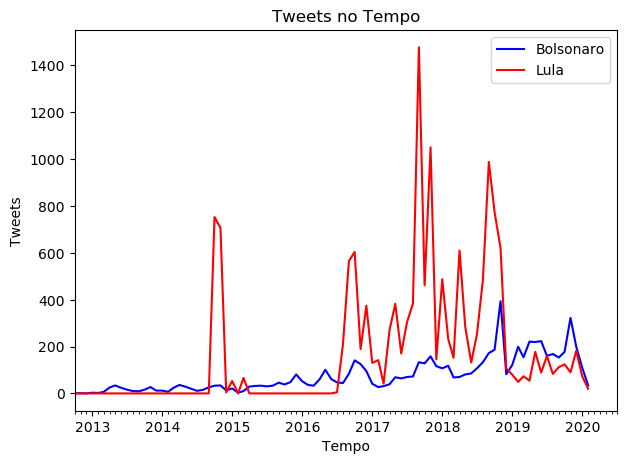

In [11]:
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator,YearLocator, DateFormatter

colors = {'jairbolsonaro': 'blue', 'LulaOficial': 'red'}

figx=7
figy=(8/10)*figx
fig,ax=plt.subplots(figsize=(figx,figy),dpi=100)
# Note that even in the OO-style, we use `.pyplot.figure` to create the figure.
# fig, ax = plt.subplots()  # Create a figure and an axes.

ax.xaxis.set_major_locator(YearLocator())
ax.xaxis.set_minor_locator(MonthLocator())
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

ax.fmt_xdata = DateFormatter('%Y-%m') # '%Y-%m-%d %H:%M:%S'
fig.autofmt_xdate()

for label in ax.get_xticklabels():
    label.set_horizontalalignment('center')

ax.set_xlim([dt.date(2012, 10, 1), dt.date(2020, 7, 1)]) # Fixed range

ax.plot(ctweets['jairbolsonaro'].index.get_level_values(0).to_numpy(), ctweets['jairbolsonaro'].to_numpy(), color='blue', label='Bolsonaro')  # Plot some data on the axes.
ax.plot(ctweets['LulaOficial'].index.get_level_values(0).to_numpy(), ctweets['LulaOficial'].to_numpy(), color='red', label='Lula')

ax.set_xlabel('Tempo')  # Add an x-label to the axes.
ax.set_ylabel('Tweets')  # Add a y-label to the axes.
ax.set_title("Tweets no Tempo")  # Add a title to the axes.
ax.legend()  # Add a legend.

### Análise de palavras e tags

Quais as palavras e tags mais utilizadas por Lula e Bolsonaro?

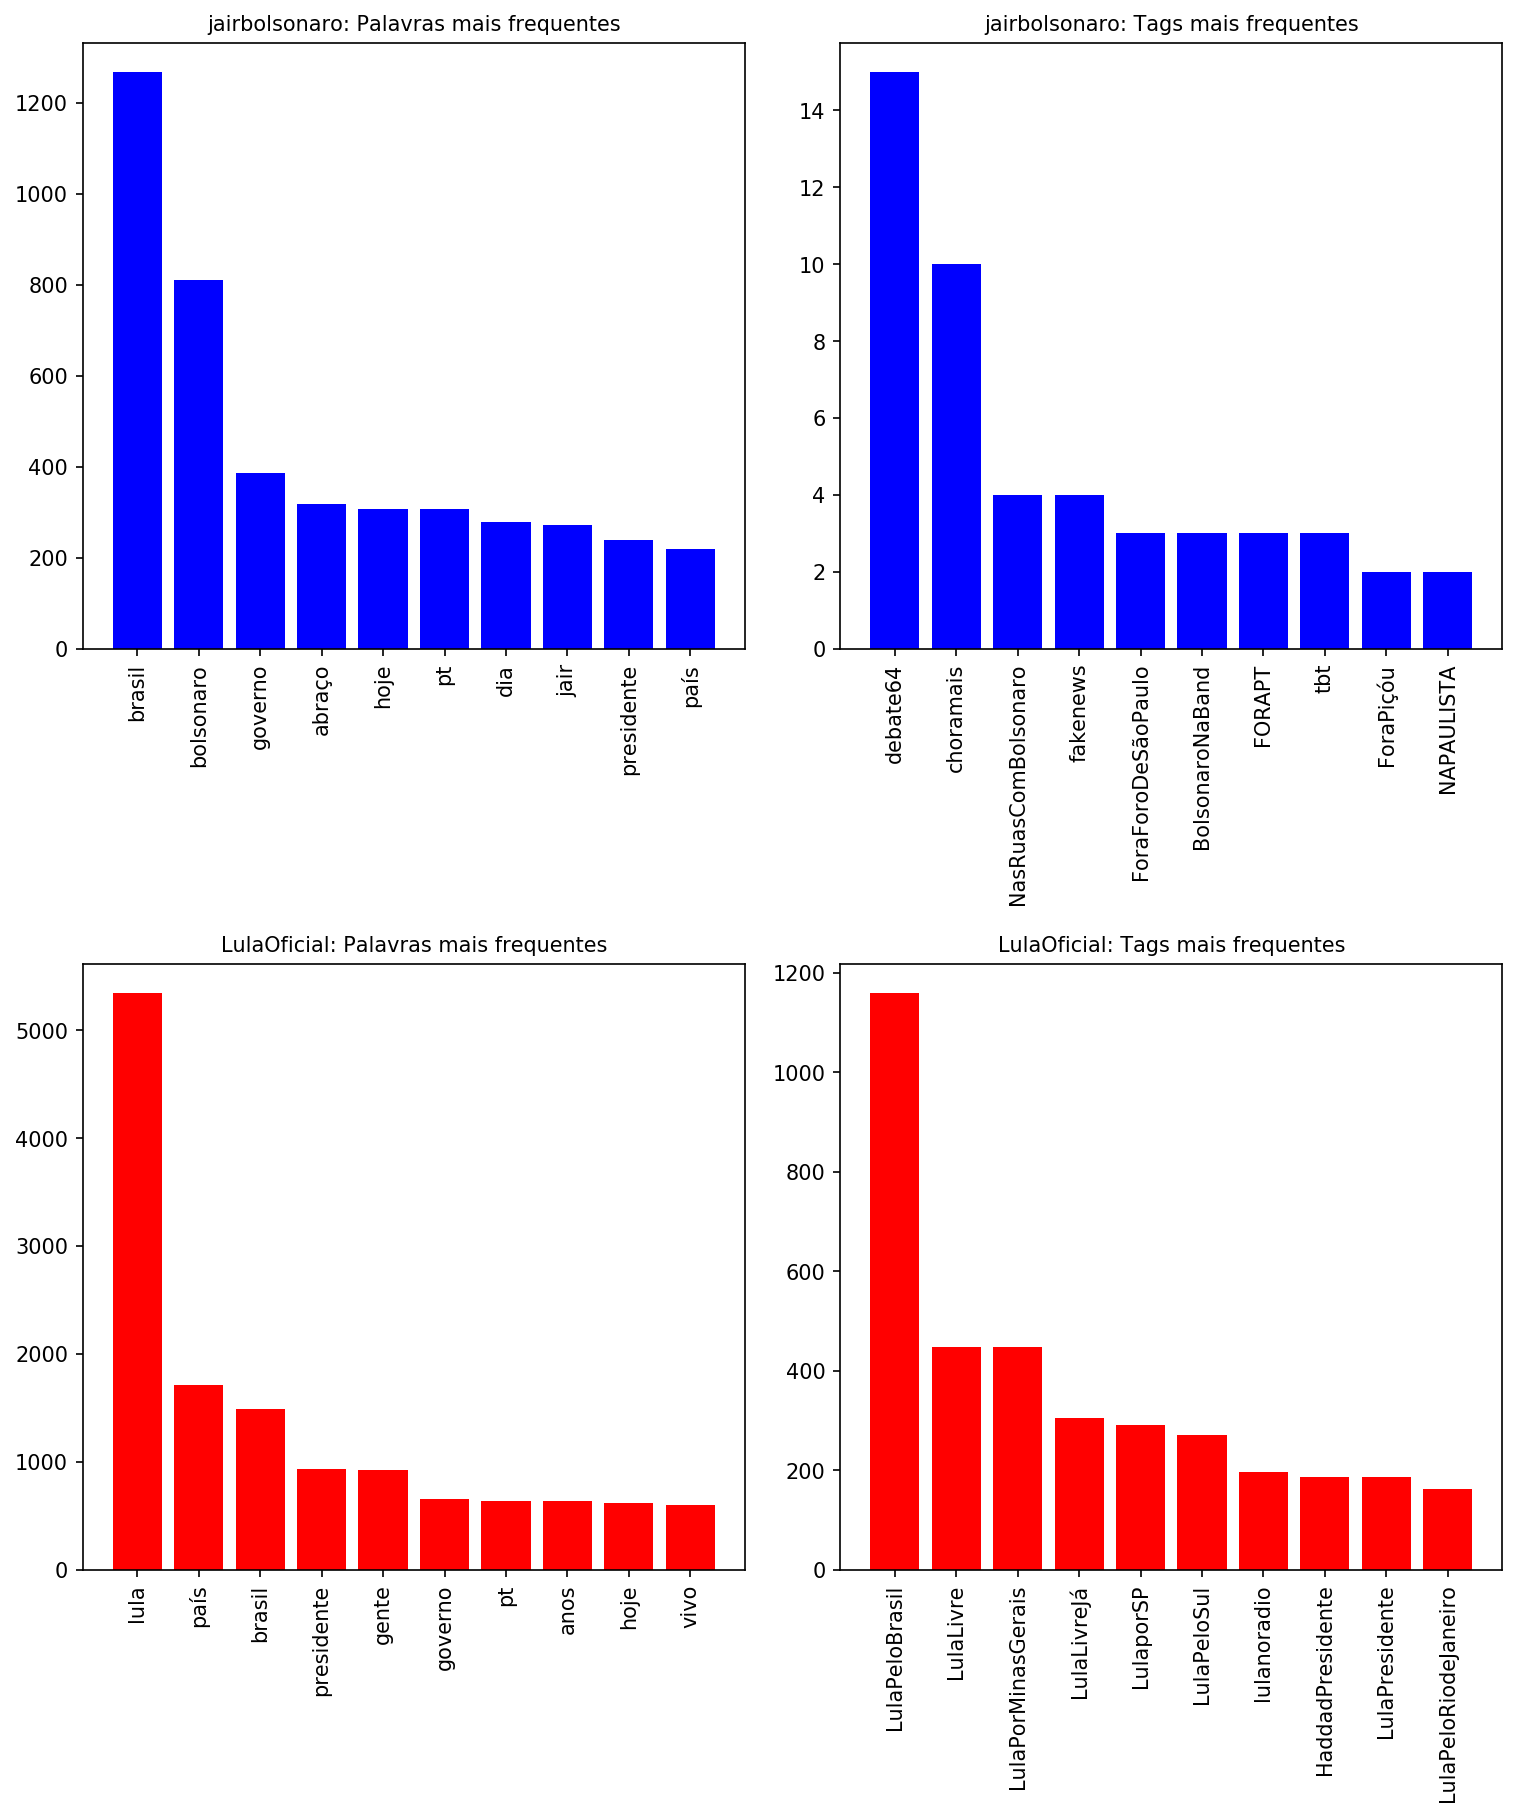

In [12]:
def plot_words_tags(row, profile):
    
    width = 0.8  # the width of the bars
    palavras = indexed_df.loc[profile, 'palavras'].dropna().explode().value_counts().head(10)
    tags = indexed_df.loc[profile, 'entities.hashtags'].dropna().explode().value_counts().head(10)
    axs[row, 0].bar(x=palavras.index, height=palavras, width=width, color=colors[profile])
    axs[row, 0].set_title("{}: Palavras mais frequentes".format(profile), fontsize=10)
    axs[row, 0].xaxis.set_tick_params(rotation=90)
    axs[row, 1].bar(x=tags.index, height=tags, width=width, color=colors[profile])
    axs[row, 1].set_title("{}: Tags mais frequentes".format(profile), fontsize=10)
    axs[row, 1].xaxis.set_tick_params(rotation=90)


figx=10
figy=1.2*figx
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(figx,figy),dpi=150, constrained_layout=True)
# fig.tight_layout(pad=12.0)

for i, profile in enumerate(profiles):
    plot_words_tags(i, profile)

Quais as palavras mais frequentes nos tuítes mais (e menos) retuítados?

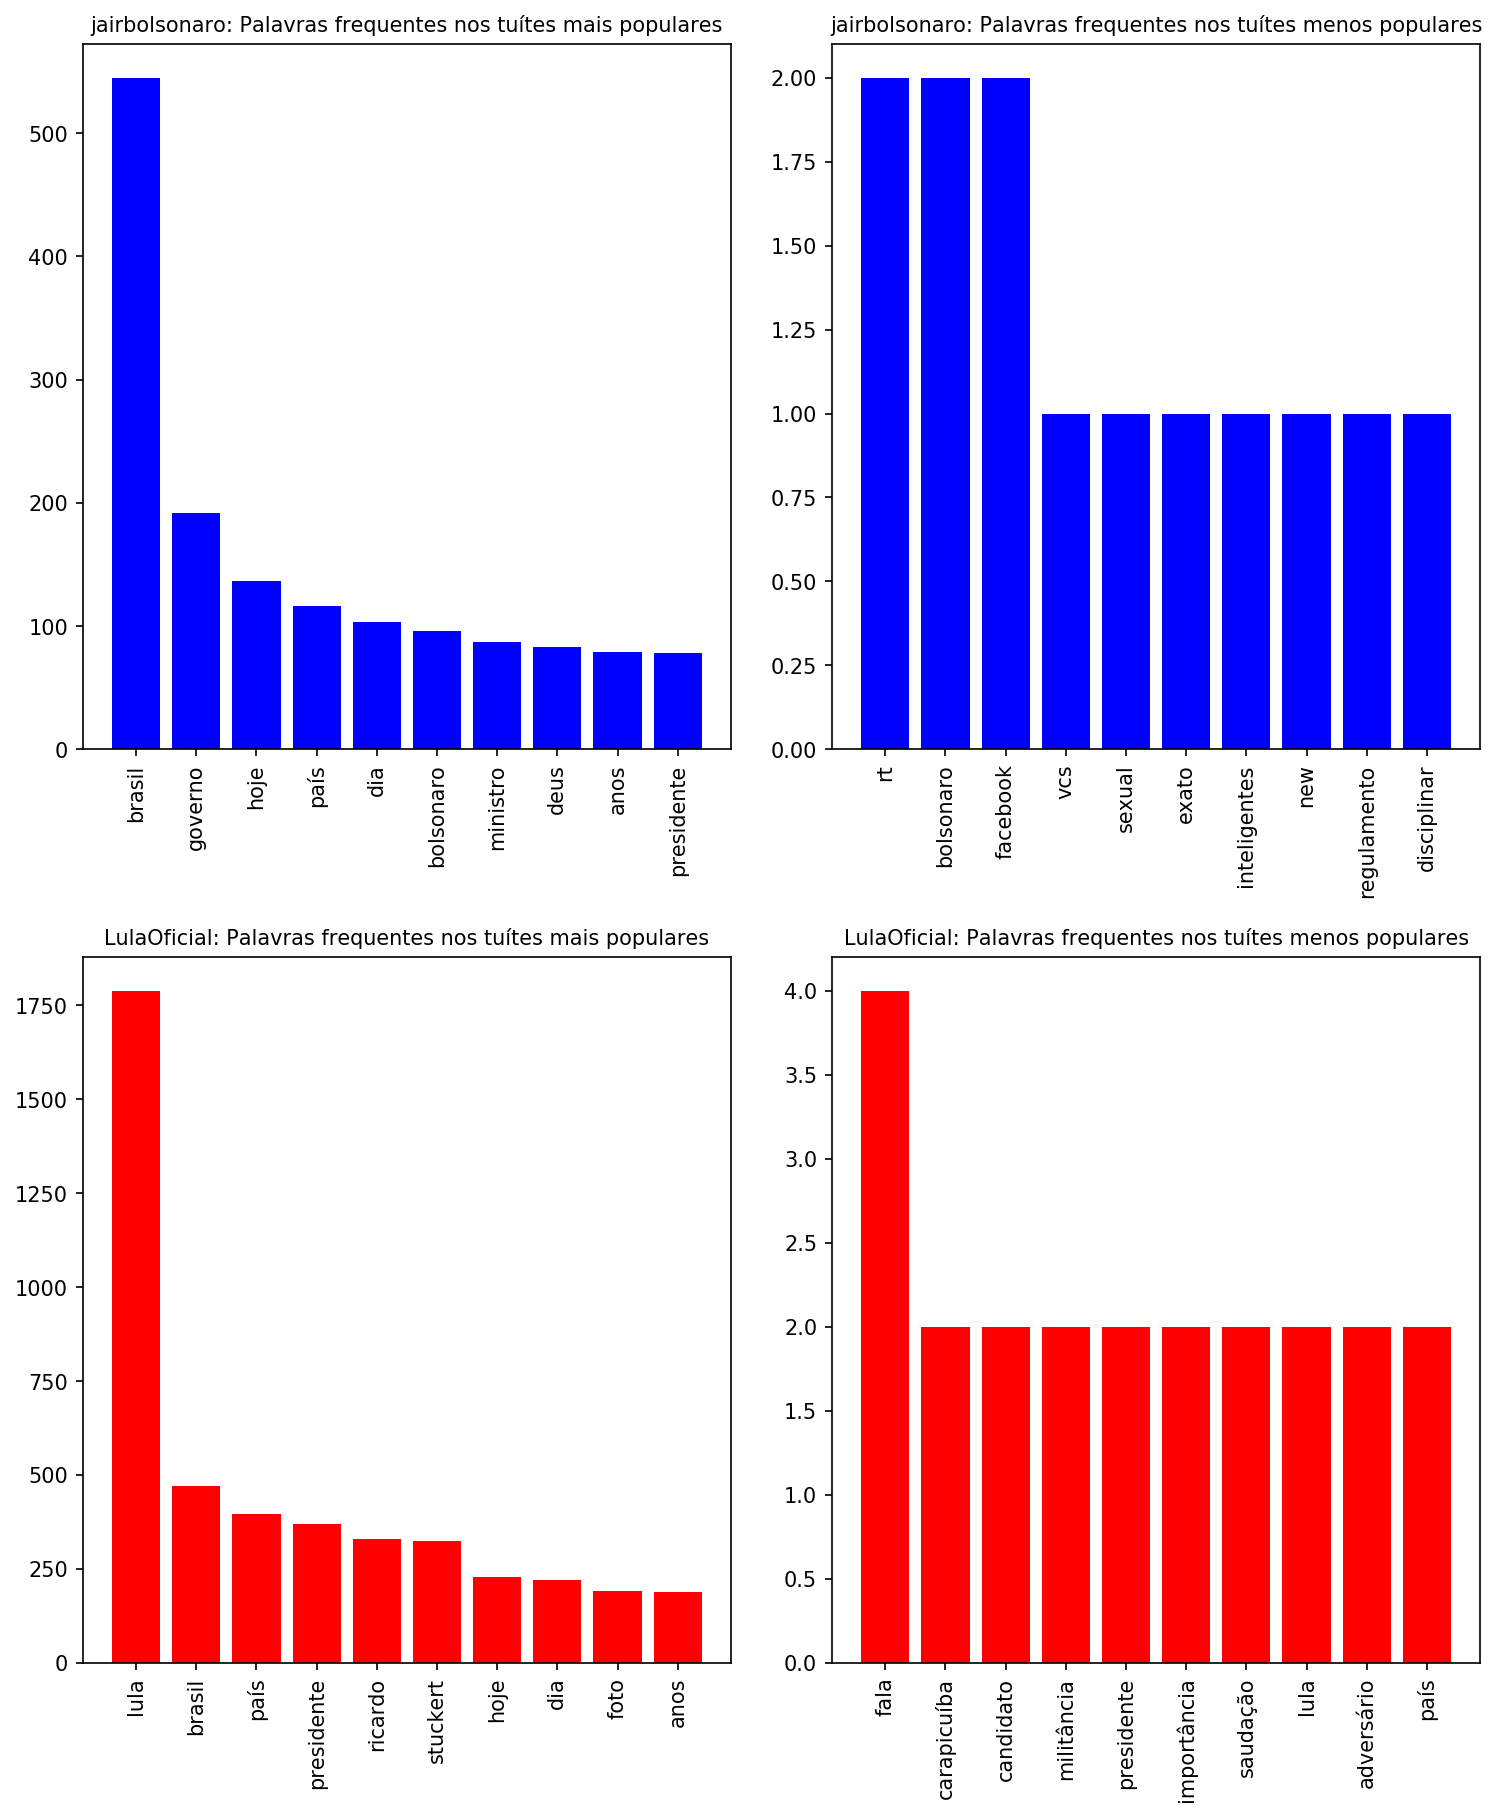

In [13]:
def plot_words_tags(row, profile):
    width = 0.8  # the width of the bars
    
    # Quantidade de retweets e favoritadas 
    popularidade = indexed_df.loc[profile]['retweet_count']
    
    perfil_df = indexed_df.loc[profile] 
    palavras_mais_retuidadas = perfil_df[perfil_df.retweet_count >= popularidade.quantile(0.75)]['palavras'].explode().value_counts().head(10)
    palavras_menos_retuidadas = perfil_df[perfil_df.retweet_count == 0]['palavras'].explode().value_counts().head(10)
    axs[row, 0].bar(x=palavras_mais_retuidadas.index, height=palavras_mais_retuidadas, width=width, color=colors[profile])
    axs[row, 0].set_title("{}: Palavras frequentes nos tuítes mais populares".format(profile), fontsize=10)
    axs[row, 0].xaxis.set_tick_params(rotation=90)
    axs[row, 1].bar(x=palavras_menos_retuidadas.index, height=palavras_menos_retuidadas, width=width, color=colors[profile])
    axs[row, 1].set_title("{}: Palavras frequentes nos tuítes menos populares".format(profile), fontsize=10)
    axs[row, 1].xaxis.set_tick_params(rotation=90)

figx=10
figy=1.2*figx
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(figx,figy),dpi=150, constrained_layout=True)
# fig.tight_layout(pad=12.0)

for i, profile in enumerate(profiles):
    plot_words_tags(i, profile)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f19db4a7290>]],
      dtype=object)

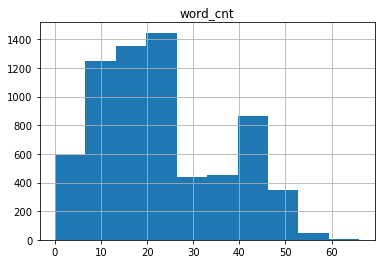

In [14]:
indexed_df.loc['jairbolsonaro'].hist('word_cnt')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f19db37b710>]],
      dtype=object)

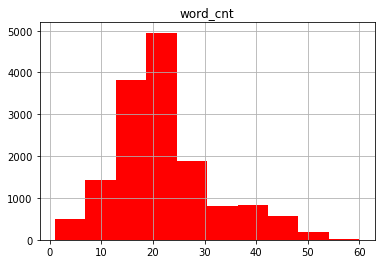

In [15]:
indexed_df.loc['LulaOficial'].hist('word_cnt', color='red')

# Referências

\[1\] [https://twitter.com](https://twitter.com/)<br>
\[2\] [https://www.facebook.com](https://www.facebook.com/)<br>
\[3\] https://sandbox.anaconda.com/<br>